In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import plotly.offline as pyo
import plotly.graph_objs as go
pyo.init_notebook_mode(connected=True)

# DTW Clustering Analysis

### ETAPA 1: padronizar os dados (de 0 a 1). Normalização linear (ver notebook de tratamento dos dados)

Os dados ja foram padronizados no pré tratamento

### Visualizações

In [277]:
# Transformando as series em lista (para ser iteradas)
import os
list_files = os.listdir('./data/')

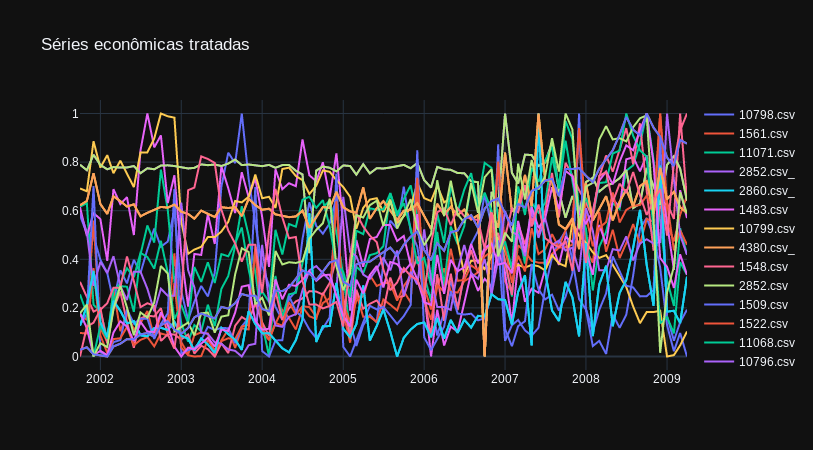

In [279]:
data = []
for file in list_files:
    temp_df = pd.read_csv('./data/'+file, index_col=0)
    x = temp_df['Data'].str.split('/')
    x = [i[1]+'-'+i[0] for i in x]
    y = temp_df[temp_df.columns[-1]].astype('float')
    trace = go.Scatter(x = x, y = y, name = file)
    data.append(trace)
    
layout = go.Layout(title = 'Séries econômicas tratadas',
                   xaxis = dict(type = 'date'),
                   template  = 'plotly_dark')
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig, filename = './plots/series_tratadas.html',config=dict(showLink = False))

In [280]:
# Criando um pandas com todas as séries
series_padronizadas = pd.DataFrame()

for file in list_files:
    temp_df = pd.read_csv('./data/'+file, index_col=0)
    x = temp_df['Data'].str.split('/')
    x = [i[1]+'-'+i[0] for i in x]
    y = temp_df[temp_df.columns[-1]].astype('float')
    trace = go.Scatter(x = x, y = y, name = file)
    data.append(trace)

### ETAPA 2: Escolher uma métrica de dissimilaridade

Deve se escolher uma métrica que gere clusters mais interpretáveis. Geralmente é definida após experimentação. No artigo analisado, se utilizou de 3 métricas para testes:
- STS - short time series
- Distância baseado em um índice de correlação cruzada
- DTW
    * Essa métrica permite comparação de séries com tamanhos diferentes (mensal com anual, por exemplo). Tudo indica que será a ideal para RORAIMA.

#### DTW (Dynamic Time Warping)
$$d_{DTW} = min \frac{\sum_{k=1}^K w_k}{K}$$

> O DTW (dynamic time warping) ou alinhamento temporal dinâmico é a
generalização dos algoritmos clássicos para comparar sequências discretas com
sequências de valores contínuos, muito usado também para comparar sequências
de DNA/RNA. 
> 
> Dado duas séries temporais , Q = q1, q2, . . . , qi, . . . , qn e R = r1, r2, . .
. , rj , . . . , rm, **DTW alinha as duas séries minimizando suas diferenças.** Para esse
fim, é construída uma matriz n × m onde o elemento (i , j) contem a distância
d ( q i , r j ) entre dois pontos q i e r j . A distância euclidiana é normalmente usada.
> 
> Programação dinâmica pode ser usada de maneira muito eficiente para encontrar
o caminho warping, utilizando o algoritmo abaixo.
> 
> $$dcum(i, j ) = d(qi, rj ) + min \{ dcum(i − 1, j − 1), dcum(i − 1, j ), dcum(i, j − 1) \}$$


**obs:** Usei a solução do pacote `tslearn`. Explorar também a solução do pacote `dtaidistance` no link abaixo:

https://dtaidistance.readthedocs.io/en/latest/modules/dtw.html

- A seguir foi aplicado o algoritmo soft-dtw, uma adaptação do algortimo DTW (Dynamic Time Warping) com suavização na função custo. Uma vez gerados os clusters com este algoritmo, as séries foram desnormalizadas e plotadas separadas de acordo com o novo grupo.

In [11]:
from tslearn.clustering import TimeSeriesKMeans
seed = 0
n = 6
sdtw_km = TimeSeriesKMeans(n_clusters=n, metric="softdtw",
                           verbose=True, random_state=seed)

- Criando um timeseries dataset com as séries coletadas

In [281]:
# Lista com todas as series
ts_list = []
ts_names = []
for file in list_files:
    temp_df = pd.read_csv('./data/'+file, index_col=0)
    name = temp_df.columns[-1]
    ts_list.append(temp_df[name].tolist())
    ts_names.append(name.split('-')[0].replace(' ',''))

In [282]:
# criando o dataset
series_padronizadas = pd.DataFrame(columns=['Data']+ts_names)
for i in range(len(list_files)):
    temp_df = pd.read_csv('./data/'+list_files[i], index_col=0)
    series_padronizadas[ts_names[i]] = temp_df[temp_df.columns[-1]]

x = temp_df['Data'].str.split('/')
x = [i[1]+'-'+i[0] for i in x]
series_padronizadas['Data'] = x
series_padronizadas = series_padronizadas.set_index('Data')

---

### Matrix de dissimilaridade

O método DTW é uma maneira de obter a dissimilaridade entre duas séries
temporais, contudo para que a geração de agrupamentos seja possível necessita-
se da dissimilaridade de uma com todas e todas com uma.

Cada elemento da matrix será a dissimilaridade das séries correspondentes i e j. Serão testadas métricas para decisão:

- DTW

In [284]:
def matrix_dtw_series(series_padronizadas):
    from tslearn.metrics import dtw
    num_series = series_padronizadas.shape[1]
    dissimilaridade = np.zeros([num_series,num_series])
    for i in range(0,num_series):
        for j in range(0,num_series):
            dissimilaridade[i][j] = dtw(series_padronizadas.values[i], series_padronizadas.values[j])
    return pd.DataFrame(dissimilaridade)

In [285]:
dissimilaridade = matrix_dtw_series(series_padronizadas)

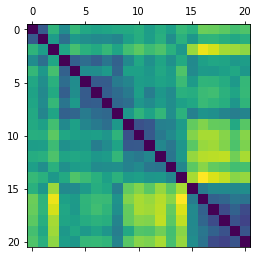

In [286]:
plt.matshow(pd.DataFrame(dissimilaridade))

### Reduzindo as dimensões com MDS (Multi Dimensional Scaling)

O objetivo é colocar a matriz de dissimilaridades em um plano bidimensional, possibilitando o uso de algoritmos de clusterização mais robustos.

https://blog.paperspace.com/dimension-reduction-with-multi-dimension-scaling/

**obs:** Estudar mais Manifold Learning: Campo que trata da redução de dimensionalidades. Ver [link1](https://prateekvjoshi.com/2014/06/21/what-is-manifold-learning/), [link2(scikit)](https://scikit-learn.org/stable/modules/manifold.html) e [link3](https://towardsdatascience.com/manifold-learning-the-theory-behind-it-c34299748fec)

In [287]:
from sklearn.manifold import MDS

mds_scaler = MDS(n_components = 2)
dissimilaridade_scaled = mds_scaler.fit_transform(dissimilaridade)

/home/breno/.virtualenvs/dtsci/lib/python3.6/site-packages/sklearn/manifold/mds.py:421: UserWarning:

The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.



In [288]:
dissimilaridade_scaled[0]#[1]

array([-0.52516433, -0.26913355])

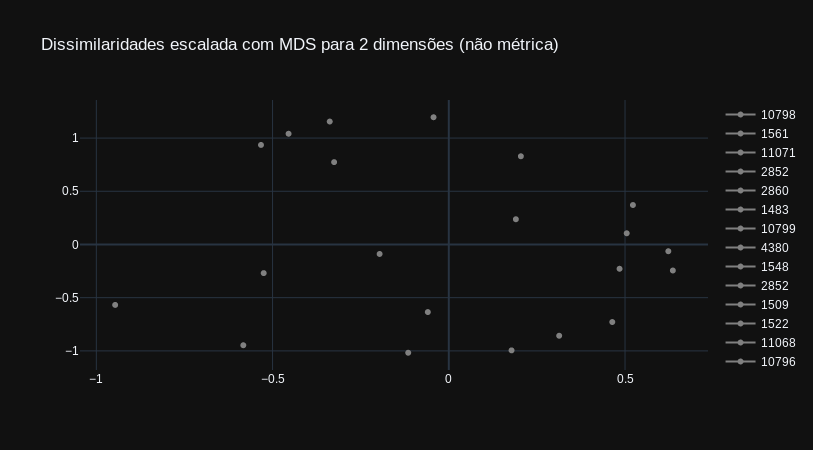

In [289]:
data = []
for i in range(0,21):
    trace = go.Scatter(x = [dissimilaridade_scaled[i][0]],
                       y = [dissimilaridade_scaled[i][1]],
                       name = ts_names[i],
                       marker = dict(color = 'gray'))
    data.append(trace)
layout = go.Layout(title = 'Dissimilaridades escalada com MDS para 2 dimensões (não métrica)',
                   template = 'plotly_dark')
fig = go.Figure(data = data, layout=layout)
pyo.iplot(fig, config=dict(showLink = False))

### Clusterizando (K-Means)

In [290]:
from sklearn.cluster import KMeans, ward_tree

kmeans_cluster = KMeans(n_clusters=5, random_state=0).fit(dissimilaridade_scaled)

labels = kmeans_cluster.labels_

dissimilaridade_kmeans = pd.DataFrame(dissimilaridade_scaled)
dissimilaridade_kmeans['cluster'] = labels.tolist()
dissimilaridade_kmeans.columns = ['x','y','cluster']

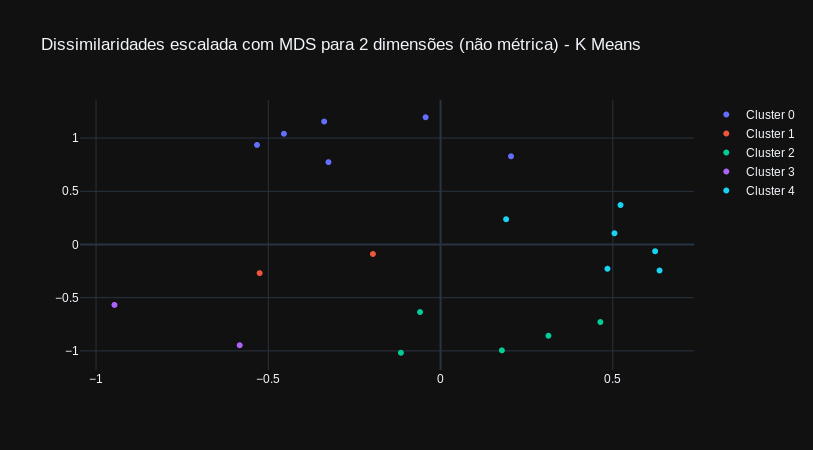

In [291]:
data = []
for i in range(0,5):
    temp_df = dissimilaridade_kmeans[dissimilaridade_kmeans['cluster'] == i]
    trace = go.Scatter(x = temp_df['x'],
                       y = temp_df['y'],
                       name = 'Cluster '+str(i),
                       mode = 'markers')
    data.append(trace)
layout = go.Layout(title = 'Dissimilaridades escalada com MDS para 2 dimensões (não métrica) - K Means',
                   template = 'plotly_dark')
fig = go.Figure(data = data, layout=layout)
pyo.iplot(fig, config=dict(showLink = False))

### Resultados do cluster 

In [292]:
resultados = pd.DataFrame()
resultados['code'] = ts_names
desc_list = []
for file in list_files:
    temp_df = pd.read_csv('./data/'+file, index_col=0)
    desc = temp_df.columns[-1]
    desc_list.append(desc)
resultados['descricao'] = desc_list
resultados['cluster'] = dissimilaridade_kmeans['cluster']

--- 

# Conclusões

In [301]:
pd.set_option('max_colwidth', 1000)

- Cluster 0

In [302]:
resultados[resultados['cluster'] == 0]

,code,descricao,cluster
15,11067,11067 - Indicadores da produção (2002=100) - Por categoria de uso - Bens de capital - Índice,0
16,2851,2851 - Investimento direto total (líquido) - mensal - US$ (milhões),0
17,2851,2851 - Investimento direto total (líquido) - mensal - US$ (milhões),0
18,10797,10797 - Distribuição de desocupados segundo o tempo de procura de emprego - De 31 dias a 6 meses - %,0
19,11070,11070 - Indicadores da produção (2002=100) - Por categoria de uso - Bens de consumo (duráveis) - Índice,0
20,4380,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),0


- Cluster 1

In [303]:
resultados[resultados['cluster'] == 1]

,code,descricao,cluster
0,10798,10798 - Distribuição de desocupados segundo o tempo de procura de emprego - De 7 a 11 meses - %,1
1,1561,1561 - Índice volume de vendas no varejo - Hipermercados e supermercados - Brasil - Índice,1


- Cluster 2

In [304]:
resultados[resultados['cluster'] == 2]

,code,descricao,cluster
9,2852,2852 - Investimento brasileiro direto - IBD (líquido) - mensal - US$ (milhões),2
10,1509,"1509 - Índice volume de vendas no varejo - Tecido, vestuário e calçado - Brasil - Índice",2
11,1522,1522 - Índice volume de vendas no varejo - Móveis e eletrodomésticos - Brasil - Índice,2
12,11068,11068 - Indicadores da produção (2002=100) - Por categoria de uso - Bens intermediários - Índice,2
13,10796,10796 - Distribuição de desocupados segundo o tempo de procura de emprego - Até 30 dias - %,2


- Cluster 3

In [305]:
resultados[resultados['cluster'] == 3]

,code,descricao,cluster
2,11071,11071 - Indicadores da produção (2002=100) - Por categoria de uso - Bens de consumo (não-duráveis e semiduráveis) - Índice,3
14,2860,2860 - Investimento estrangeiro direto - IED (líquido) - mensal - US$ (milhões),3


- Cluster 4

In [306]:
resultados[resultados['cluster'] == 4]

,code,descricao,cluster
3,2852,2852 - Investimento brasileiro direto - IBD (líquido) - mensal - US$ (milhões),4
4,2860,2860 - Investimento estrangeiro direto - IED (líquido) - mensal - US$ (milhões),4
5,1483,1483 - Índice volume de vendas no varejo - Combustíveis e lubrificantes - Brasil - Índice,4
6,10799,10799 - Distribuição de desocupados segundo o tempo de procura de emprego - Mais de 1 ano - %,4
7,4380,4380 - PIB mensal - Valores correntes (R$ milhões) - R$ (milhões),4
8,1548,"1548 - Índice volume de vendas no varejo - Automóveis, motocicletas, partes e peças - Brasil - Índice",4
